In [1]:
import pandas as pd
from pathlib import Path
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt, image as img
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    ReLU,
    Flatten,
    Dense,
    UpSampling2D,
)
from tensorflow.keras.models import Model, Sequential
from skimage.transform import resize
from tensorflow import Tensor
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input
from tensorflow import Tensor
from scipy.stats import mannwhitneyu
from tabulate import tabulate

!pip install progressbar
import progressbar

# random seed generator
np.random.seed(3)
tf.random.set_seed(7)

2021-09-16 10:47:06.379738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=9ee214c8c494cb9bee0a47953f9b5042dde8ea935ecda34ee969fa6e164dd8c9
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [2]:
def load_raw_data():

    covid_path = "../input/large-covid19-ct-slice-dataset/curated_data/curated_data/2COVID"
    non_covid_path = "../input/large-covid19-ct-slice-dataset/curated_data/curated_data/1NonCOVID"

    covid_images = list(Path(covid_path).glob("*.png"))
    non_covid_images = list(Path(non_covid_path).glob("*.png"))

    # To visualize the dataset
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    image = img.imread(covid_images[1])
    plt.imshow(image)
    plt.title("CT Scan of Covid Affected Lungs")

    fig.add_subplot(1, 2, 2)
    image = img.imread(non_covid_images[1])
    plt.imshow(image)
    plt.title("CT Scan of Healthy Lungs")
    return covid_images, non_covid_images


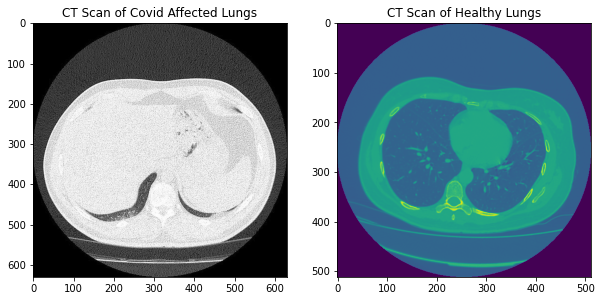

In [3]:
# To convert .png image files to .npy numpy arrays

covid_images, non_covid_images = load_raw_data()
IMG_SIZE = 128

# Two empty numpy arrays to store coverted images
positive_npy = np.empty((len(covid_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
negative_npy = np.empty((len(non_covid_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

# start a bar of show percentage of loading data 
covid_bar = progressbar.ProgressBar(maxval=len(covid_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
non_covid_bar = progressbar.ProgressBar(maxval=len(non_covid_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])


In [4]:
covid_bar.start()
# Converting COVID dataset to .npy format
for i, _file in enumerate(covid_images):
    try:
        image_npy = img.imread(_file)
        positive = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        positive_npy[i] = positive
    except:
        pass
    covid_bar.update(i+1)
    
covid_bar.finish()
print("COVID images converting done")

COVID images converting done


In [5]:
non_covid_bar.start()
# Converting non-COVID dataset to .npy format
for i, _file in enumerate(non_covid_images):
    try:
        image_npy = img.imread(_file)
        negative = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        negative_npy[i] = negative
    except:
        print("cant open image " + i + "th") 
        
    non_covid_bar.update(i+1)
non_covid_bar.finish()
print("non covid images converting done") 

non covid images converting done


In [6]:
print(positive_npy.shape)
print(negative_npy.shape)

(7593, 128, 128, 1)
(6893, 128, 128, 1)


In [7]:
# To load dataset and concat them to x and y
def load_data():
    positive = positive_npy
    positive_labels = ["1" for i in positive]
    negative = negative_npy
    negative_labels = ["0" for i in negative]

    # Joining both datasets and labels
    X = np.concatenate([positive, negative])
    y = np.array((positive_labels + negative_labels), dtype=np.float32)
    return X, y

In [8]:
# CNN model
def cnn():
    model = Sequential()
    # convulutional layer
    model.add(
        Conv2D(
            32,
            kernel_size=5,
            activation="relu",
            input_shape=(128, 128, 1),
        )
    )
    # Normalising after activation
    model.add(BatchNormalization())    
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(256, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    # fully connected layer
    model.add(Dense(200, activation="relu"))
    # output
    model.add(Dense(2, activation="softmax"))
    model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer= keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0),
        metrics=["accuracy"],
    )
    return model


In [9]:
X, y = load_data()
print(X.shape)
print(y.shape)

(14486, 128, 128, 1)
(14486,)


In [10]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = cnn()

model.summary()


2021-09-16 10:54:49.531509: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-16 10:54:49.535442: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-16 10:54:49.581131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-16 10:54:49.582072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-16 10:54:49.582129: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-16 10:54:49.628593: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      832       
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 58, 58, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       2

In [11]:
history_cnn = model.fit(
    X_train,
    y_train,
    epochs=20,
    workers=4,
    validation_data=(X_test, y_test),
)

2021-09-16 10:54:52.336153: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 759431168 exceeds 10% of free system memory.
2021-09-16 10:54:52.931789: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-16 10:54:52.945693: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


Epoch 1/20


2021-09-16 10:54:53.748579: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-16 10:54:54.588482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-16 10:54:54.609704: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


363/363 [==============================] - 15s 20ms/step - loss: 0.4430 - accuracy: 0.8158 - val_loss: 1.6187 - val_accuracy: 0.4752
Epoch 2/20
363/363 [==============================] - 6s 18ms/step - loss: 0.2233 - accuracy: 0.9085 - val_loss: 0.2010 - val_accuracy: 0.9172
Epoch 3/20
363/363 [==============================] - 6s 18ms/step - loss: 0.1557 - accuracy: 0.9360 - val_loss: 0.1560 - val_accuracy: 0.9396
Epoch 4/20
363/363 [==============================] - 6s 18ms/step - loss: 0.1091 - accuracy: 0.9570 - val_loss: 0.1222 - val_accuracy: 0.9520
Epoch 5/20
363/363 [==============================] - 7s 18ms/step - loss: 0.0610 - accuracy: 0.9772 - val_loss: 0.1241 - val_accuracy: 0.9517
Epoch 6/20
363/363 [==============================] - 6s 18ms/step - loss: 0.0531 - accuracy: 0.9812 - val_loss: 0.1284 - val_accuracy: 0.9510
Epoch 7/20
363/363 [==============================] - 6s 18ms/step - loss: 0.0198 - accuracy: 0.9932 - val_loss: 0.0781 - val_accuracy: 0.9700
Epoch 8/2

In [12]:
y_pred = model.predict(X_test)
predicted = np.argmax(y_pred, axis=-1)
accuracy = np.equal(y_test, predicted).mean()
print("Accuracy:", accuracy)

Accuracy: 0.9817115251897861


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1377
         1.0       0.99      0.97      0.98      1521

    accuracy                           0.98      2898
   macro avg       0.98      0.98      0.98      2898
weighted avg       0.98      0.98      0.98      2898



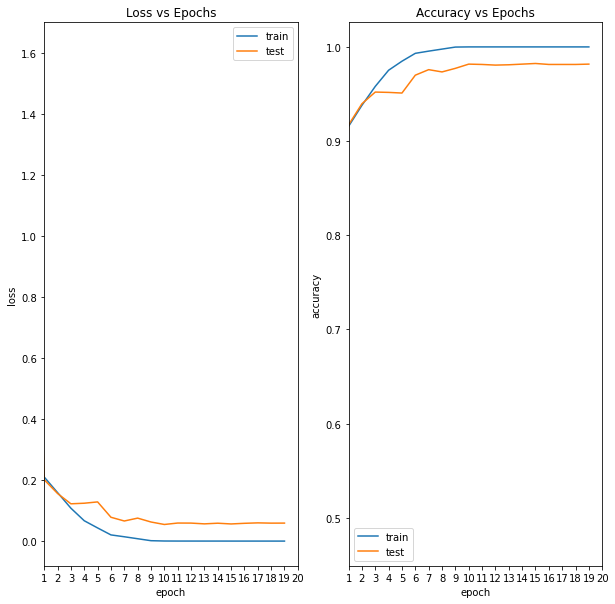

In [14]:

# To plot learning curves
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].set_title("Loss vs Epochs")
ax[0].plot(history_cnn.history["loss"])
ax[0].plot(history_cnn.history["val_loss"])
ax[0].legend(["train", "test"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].set_xlim(1, 20)
ax[0].set_xticks(range(1, 21))

ax[1].set_title("Accuracy vs Epochs")
ax[1].plot(history_cnn.history["accuracy"])
ax[1].plot(history_cnn.history["val_accuracy"])
ax[1].legend(["train", "test"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].set_xlim(1, 20)
ax[1].set_xticks(range(1, 21))

plt.show()


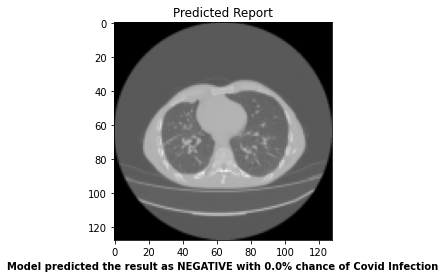

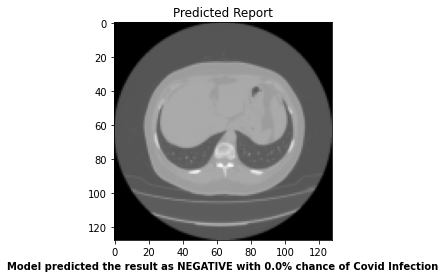

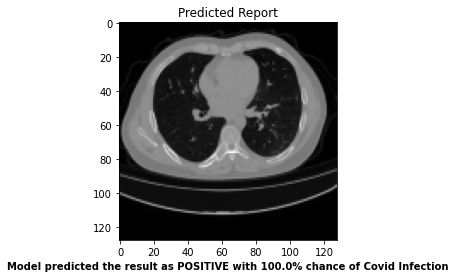

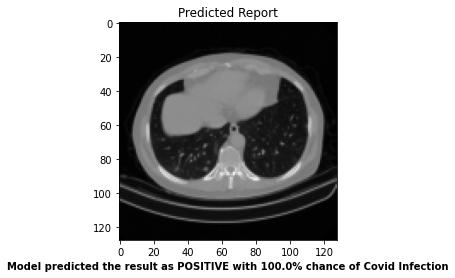

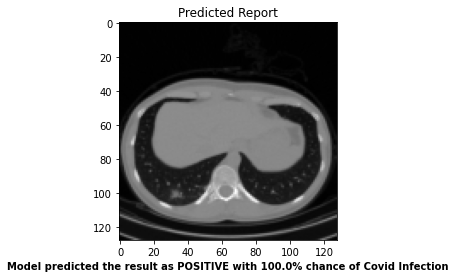

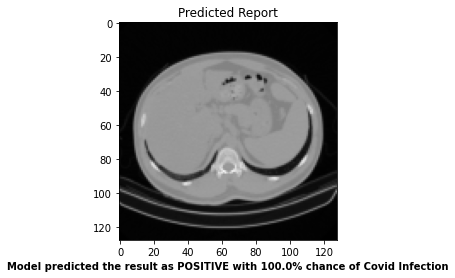

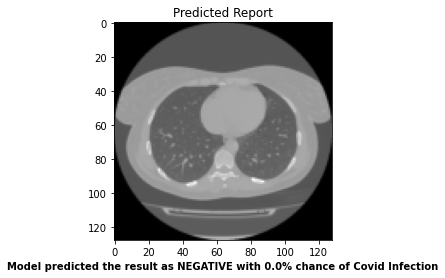

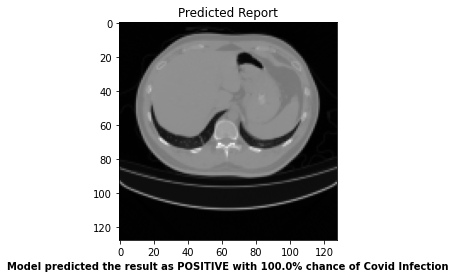

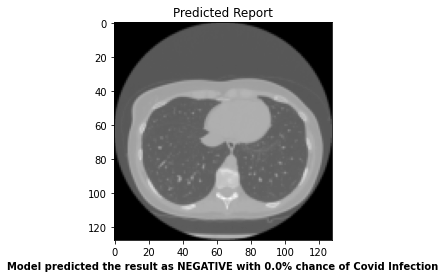

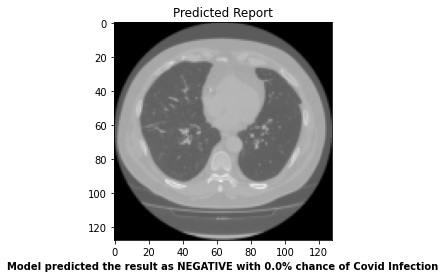

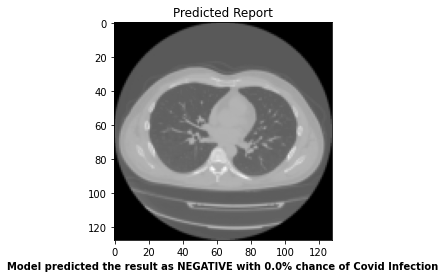

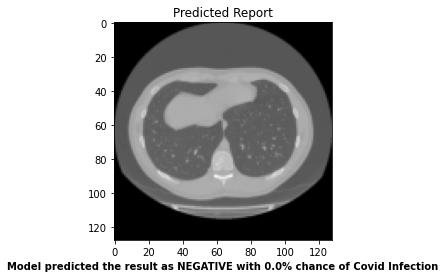

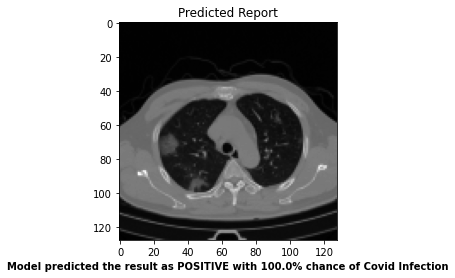

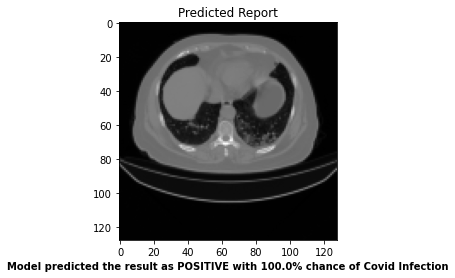

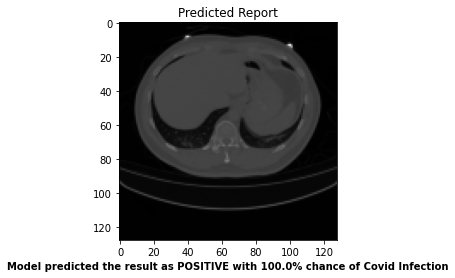

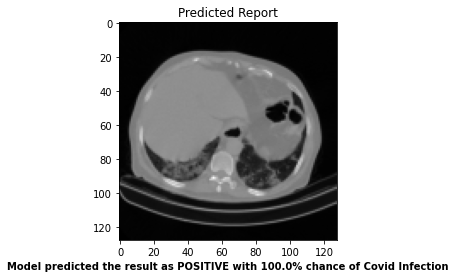

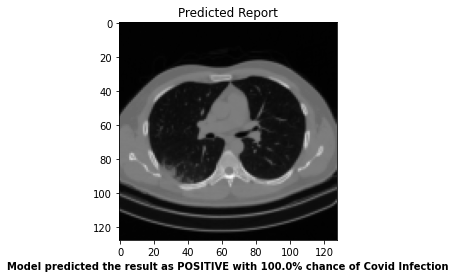

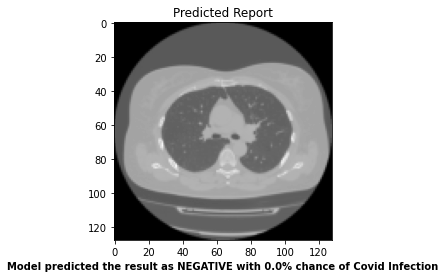

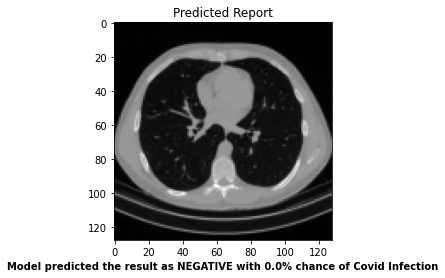

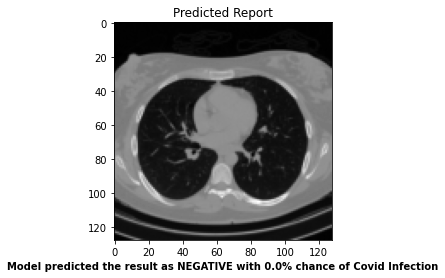

In [15]:
# To print the final report
j = 0
k = 0
for i, label in enumerate(y_pred):

    # Report for positive predicted cases
    if (np.argmax(y_pred[i]) == 1.0) and (j < 10):
        plt.title("Predicted Report")
        plt.imshow(X_test[i].squeeze(), cmap="gray")
        plt.xlabel(
            "Model predicted the result as POSITIVE with "
            + str(round((np.max(label) * 100), 2))
            + "% chance of Covid Infection",
            fontweight="bold",
        )

        plt.show()
        j = j + 1

    # Report for negative predicted cases
    if (np.argmax(y_pred[i]) == 0.0) and (k < 10):
        plt.title("Predicted Report")
        plt.imshow(X_test[i].squeeze(), cmap="gray")
        plt.xlabel(
            "Model predicted the result as NEGATIVE with "
            + str(round((np.min(label) * 100), 2))
            + "% chance of Covid Infection",
            fontweight="bold",
        )
        plt.show()
        k = k + 1
